In [29]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd
from skimage.color import rgb2hsv
from skimage.feature import local_binary_pattern # Added for LBP texture features
from skimage.morphology import opening, closing, disk

In [30]:
# Helper functions
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=img.dtype)
        gt_img_3c[:, :, 0] = gt_img
        gt_img_3c[:, :, 1] = gt_img
        gt_img_3c[:, :, 2] = gt_img
        cimg = np.concatenate((img, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

In [31]:
root_dir = "training/" 

image_dir = os.path.join(root_dir, "images/")
gt_dir = os.path.join(root_dir, "groundtruth/")

if not os.path.exists(image_dir) or not os.path.exists(gt_dir):
    print(f"Error: Ensure '{image_dir}' and '{gt_dir}' exist.")
    # You might want to stop execution here if directories are missing
    sys.exit()
else:
    files = sorted(os.listdir(image_dir)) # Sort to ensure consistent order
    gt_files = sorted(os.listdir(gt_dir))

    # Filter out non-image files if any and ensure corresponding ground truth exists
    valid_files = [f for f in files if os.path.exists(os.path.join(gt_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff'))]

    if not valid_files:
        print("No valid image files found in 'images' with corresponding ground truth files.")
        sys.exit()
    else:
        # Load maximum 100 images, or fewer if not available
        n = min(100, len(valid_files))
        print(f"Loading {n} images and their ground truths...")

        imgs = [load_image(os.path.join(image_dir, valid_files[i])) for i in range(n)]
        gt_imgs = [load_image(os.path.join(gt_dir, valid_files[i])) for i in range(n)]
        
        # Store the filenames being used, helpful for debugging later
        loaded_filenames = valid_files[:n]
        print(f"Loaded images: {loaded_filenames}")


Loading 100 images and their ground truths...
Loaded images: ['satImage_001.png', 'satImage_002.png', 'satImage_003.png', 'satImage_004.png', 'satImage_005.png', 'satImage_006.png', 'satImage_007.png', 'satImage_008.png', 'satImage_009.png', 'satImage_010.png', 'satImage_011.png', 'satImage_012.png', 'satImage_013.png', 'satImage_014.png', 'satImage_015.png', 'satImage_016.png', 'satImage_017.png', 'satImage_018.png', 'satImage_019.png', 'satImage_020.png', 'satImage_021.png', 'satImage_022.png', 'satImage_023.png', 'satImage_024.png', 'satImage_025.png', 'satImage_026.png', 'satImage_027.png', 'satImage_028.png', 'satImage_029.png', 'satImage_030.png', 'satImage_031.png', 'satImage_032.png', 'satImage_033.png', 'satImage_034.png', 'satImage_035.png', 'satImage_036.png', 'satImage_037.png', 'satImage_038.png', 'satImage_039.png', 'satImage_040.png', 'satImage_041.png', 'satImage_042.png', 'satImage_043.png', 'satImage_044.png', 'satImage_045.png', 'satImage_046.png', 'satImage_047.png'

Image: satImage_001.png
Image size = 400, 400


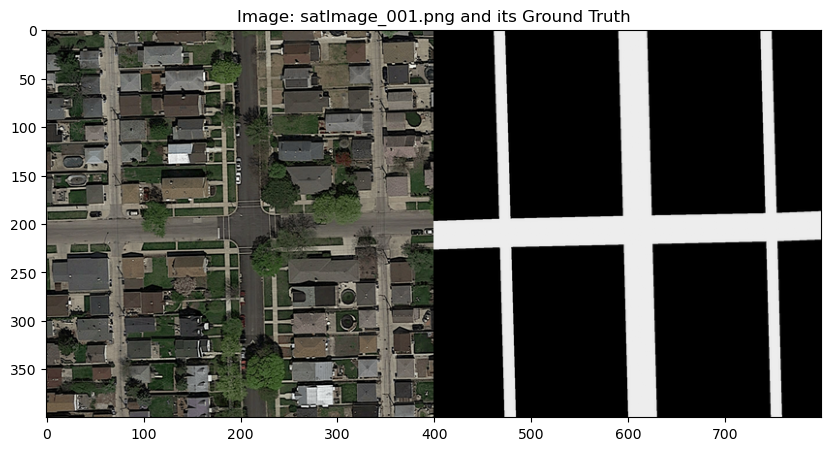

In [32]:
if 'imgs' in locals() and len(imgs) > 0:
    print(f"Image: {loaded_filenames[0]}")
    print(f"Image size = {imgs[0].shape[0]}, {imgs[0].shape[1]}")

    # Show first image and its groundtruth image
    cimg = concatenate_images(imgs[0], gt_imgs[0])
    fig1 = plt.figure(figsize=(10, 10))
    plt.imshow(cimg) # cmap="Greys_r" is often good for single channel, but concatenate_images tries to make it 3-channel
    plt.title(f"Image: {loaded_filenames[0]} and its Ground Truth")
    plt.show()
else:
    print("No images loaded to display.")

In [33]:
patch_size = 16  # each patch is 16*16 pixels

if 'imgs' in locals() and len(imgs) > 0:
    img_patches_list = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
    gt_patches_list = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

    img_patches = np.asarray([patch for sublist in img_patches_list for patch in sublist])
    gt_patches = np.asarray([patch for sublist in gt_patches_list for patch in sublist])
    print(f"Total number of {patch_size}x{patch_size} patches extracted: {len(img_patches)}")
else:
    print("No images loaded to extract patches from.")
    img_patches = np.array([])
    gt_patches = np.array([])

Total number of 16x16 patches extracted: 62500


In [34]:
def extract_combined_features(patch):
    """
    Extracts a combination of HSV/RGB color features and Texture features.
    """
    # This initial part is the same
    if patch.dtype != np.uint8:
        if np.max(patch) <= 1.0 and np.min(patch) >=0.0 :
            patch_uint8 = (patch * 255).astype(np.uint8)
        else:
            patch_uint8 = patch.astype(np.uint8)
    else:
        patch_uint8 = patch

    # --- THE FIX IS IN THIS LOGIC BLOCK ---
    if len(patch_uint8.shape) == 2:
        # It's grayscale, convert to 3-channel RGB
        patch_rgb = np.stack((patch_uint8,)*3, axis=-1)
    elif patch_uint8.shape[2] == 1:
        # It's single-channel, convert to 3-channel RGB
        patch_rgb = np.concatenate([patch_uint8, patch_uint8, patch_uint8], axis=2)
    elif patch_uint8.shape[2] == 4:
        # It's RGBA, convert to 3-channel RGB
        patch_rgb = patch_uint8[:,:,:3]
    else:
        # If none of the above, assume it's already a 3-channel RGB image
        patch_rgb = patch_uint8

    if patch_rgb.shape[0] == 0 or patch_rgb.shape[1] == 0:
        return np.zeros(26) # Match new feature length

    # 1. Color Features (12 features)
    hsv_patch = rgb2hsv(patch_rgb)
    h_mean, s_mean, v_mean = hsv_patch[:, :, 0].mean(), hsv_patch[:, :, 1].mean(), hsv_patch[:, :, 2].mean()
    h_var, s_var, v_var = hsv_patch[:, :, 0].var(), hsv_patch[:, :, 1].var(), hsv_patch[:, :, 2].var()
    patch_rgb_float = patch_rgb.astype(float) / 255.0
    rgb_mean = np.mean(patch_rgb_float, axis=(0, 1))
    rgb_var = np.var(patch_rgb_float, axis=(0, 1))
    color_features = np.concatenate([[h_mean, s_mean, v_mean, h_var, s_var, v_var], rgb_mean, rgb_var])

    # 2. Texture Features
    gray_patch = np.dot(patch_rgb[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_patch, n_points, radius, method='uniform')
    
    lbp_mean = lbp.mean()
    lbp_var = lbp.var()
    gray_mean = gray_patch.mean()
    gray_var = gray_patch.var()
    gray_hist, _ = np.histogram(gray_patch.ravel(), bins=10, range=(0, 256))
    gray_hist_sum = gray_hist.sum()
    gray_hist = gray_hist.astype('float') / (gray_hist_sum if gray_hist_sum > 0 else 1.0)
    
    scalar_texture_features = [gray_mean, gray_var, lbp_mean, lbp_var]
    texture_features = np.concatenate([scalar_texture_features, gray_hist])

    # 3. Combine feature sets
    return np.concatenate([color_features, texture_features])
# Helper function for prediction on a full image using our new feature extractor
def extract_img_features_combined(image_path):
    img = load_image(image_path)
    patches = img_crop(img, patch_size, patch_size)
    features = np.asarray([extract_combined_features(patch) for patch in patches])
    return features, patches, img

print("New combined feature extractor (Color + Texture) is defined.")


New combined feature extractor (Color + Texture) is defined.


In [35]:
if img_patches.size > 0:
    foreground_threshold = 0.25
    def patch_to_label(patch):
        if len(patch.shape) == 3:
            patch_gray = np.mean(patch, axis=2)
        else:
            patch_gray = patch
        if np.max(patch_gray) > 1.0:
            patch_gray = patch_gray / 255.0
        return 1 if np.mean(patch_gray) > foreground_threshold else 0

    print("Extracting combined features for each patch...")
    # Use the new combined feature extractor
    X = np.asarray([extract_combined_features(p) for p in img_patches])
    Y = np.asarray([patch_to_label(p) for p in gt_patches])
    
    # Remove any rows with NaN or Inf values that might arise from variance calculations
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        print("NaN or Inf values found in feature matrix, cleaning data...")
        is_finite = np.all(np.isfinite(X), axis=1)
        X = X[is_finite]
        Y = Y[is_finite]

    print(f"Features (X) shape: {X.shape}")
    print(f"Labels (Y) shape: {Y.shape}")
else:
    print("No patches available to compute features and labels.")
    X, Y = np.array([]), np.array([])

Extracting combined features for each patch...
Features (X) shape: (62500, 26)
Labels (Y) shape: (62500,)


Training set size: 46875 patches
Test set size: 15625 patches
Total number of patches: 62500
Feature dimension: 26
Classes found: [0 1]
  Class 0: 46309 patches (74.09%)
  Class 1: 16191 patches (25.91%)


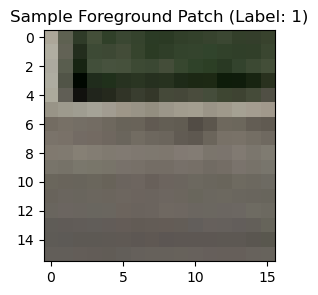

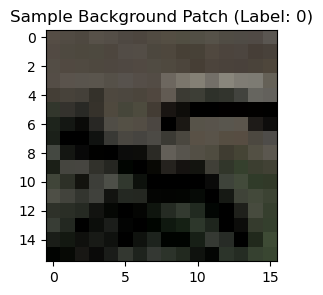

In [36]:
if X.size > 0 and Y.size > 0:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)
    print(f"Training set size: {X_train.shape[0]} patches")
    print(f"Test set size: {X_test.shape[0]} patches")
    
    print(f"Total number of patches: {X.shape[0]}")
    print(f"Feature dimension: {X.shape[1]}") # Should be 12 now
    unique_classes, counts = np.unique(Y, return_counts=True)
    print(f"Classes found: {unique_classes}")
    for cls, count in zip(unique_classes, counts):
        print(f"  Class {cls}: {count} patches ({count*100/X.shape[0]:.2f}%)")

    Y_fg_indices = np.where(Y == 1)[0]
    Y_bg_indices = np.where(Y == 0)[0]

    if len(Y_fg_indices) > 0 :
        plt.figure(figsize=(3,3))
        plt.imshow(img_patches[Y_fg_indices[0]])
        plt.title(f"Sample Foreground Patch (Label: {Y[Y_fg_indices[0]]})")
        plt.show()
    if len(Y_bg_indices) > 0:
        plt.figure(figsize=(3,3))
        plt.imshow(img_patches[Y_bg_indices[0]])
        plt.title(f"Sample Background Patch (Label: {Y[Y_bg_indices[0]]})")
        plt.show()
else:
    X_train, X_test, Y_train, Y_test = [np.array([])]*4
    print("No data to show statistics or sample patches.")

In [37]:
if X_train.size > 0:
    print("Starting hyperparameter tuning with GridSearchCV...")
    # Define the parameter grid to search
    # --- MODIFIED: Added 'max_features' and 'criterion' to the grid ---
    param_grid = {
        'n_estimators': [100, 200, 300],         # Number of trees
        'max_depth': [10, 20, 30],       # Maximum depth of the tree
        'min_samples_leaf': [1, 2, 3],        # Minimum samples required at a leaf node
        # 'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
        # 'criterion': ['gini', 'entropy']   # Function to measure the quality of a split
    }
    
    # Instantiate the RandomForestClassifier
    rf = RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1)
    
    # Instantiate the GridSearchCV object
    # cv=3 means 3-fold cross-validation.
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='f1')
    
    # Fit the grid search to the data
    grid_search.fit(X_train, Y_train)
    
    print("\nGridSearchCV training complete.")
    print("Best parameters found: ", grid_search.best_params_)
    
    # Use the best estimator found by the grid search as our final model
    best_rf_classifier = grid_search.best_estimator_
else:
    print("No training data available.")
    best_rf_classifier = None

Starting hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   6.4s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   6.5s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   6.5s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   6.8s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   6.7s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=200; total time=  13.1s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   6.7s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=200; total time=  13.5s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=200; total time=  13.4s
[CV] END .max_depth=20, min_samples_leaf=1, n_estimators=100; total time=   9.6s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=200; total time=  13

In [38]:
if best_rf_classifier and X_test.size > 0:
    print("\nEvaluating the optimized model on the Test Set:")
    Y_pred_test = best_rf_classifier.predict(X_test)

    print("\nConfusion Matrix:")
    print(confusion_matrix(Y_test, Y_pred_test))
    
    print("\nClassification Report (Precision, Recall, F1-score):")
    print(classification_report(Y_test, Y_pred_test, target_names=['Background (0)', 'Road (1)']))
    
    f1 = f1_score(Y_test, Y_pred_test, pos_label=1)
    print(f"F1-score for Road (Class 1): {f1:.4f}")
else:
    print("Model not trained or no test data to evaluate.")


Evaluating the optimized model on the Test Set:

Confusion Matrix:
[[10250  1327]
 [ 1501  2547]]

Classification Report (Precision, Recall, F1-score):
                precision    recall  f1-score   support

Background (0)       0.87      0.89      0.88     11577
      Road (1)       0.66      0.63      0.64      4048

      accuracy                           0.82     15625
     macro avg       0.76      0.76      0.76     15625
  weighted avg       0.82      0.82      0.82     15625

F1-score for Road (Class 1): 0.6430


In [39]:
def label_to_img(imgwidth, imgheight, patch_w, patch_h, labels):
    im = np.zeros([imgwidth, imgheight], dtype=np.uint8)
    idx = 0
    for i in range(0, imgheight, patch_h):
        for j in range(0, imgwidth, patch_w):
            if idx < len(labels):
                row_end = min(j + patch_w, imgwidth)
                col_end = min(i + patch_h, imgheight)
                im[j:row_end, i:col_end] = labels[idx] * 255
                idx += 1
    return im

def make_img_overlay(img, predicted_mask_bw):
    if img.dtype != np.uint8:
        if np.max(img) <= 1.0:
             img_uint8 = (img * 255).astype(np.uint8)
        else:
             img_uint8 = img.astype(np.uint8)
    else:
        img_uint8 = img.copy()

    if len(img_uint8.shape) == 2:
        img_uint8 = np.stack((img_uint8,)*3, axis=-1)
    elif img_uint8.shape[2] == 4:
        img_uint8 = img_uint8[:,:,:3]

    color_mask = np.zeros_like(img_uint8)
    color_mask[predicted_mask_bw == 255] = [255, 0, 0]
    img_pil = Image.fromarray(img_uint8)
    overlay_pil = Image.fromarray(color_mask)
    blended_img_pil = Image.blend(img_pil, overlay_pil, alpha=0.4)
    return np.array(blended_img_pil)

def cleanup_mask(mask):
    selem = disk(2)
    mask_bool = mask > 128
    opened_mask_bool = opening(mask_bool, selem)
    cleaned_mask_bool = closing(opened_mask_bool, selem)
    return (cleaned_mask_bool * 255).astype(np.uint8)

print("Image utility functions are defined.")

Image utility functions are defined.


Displaying predictions for the first 3 training images...

Predicting on training image: satImage_001.png


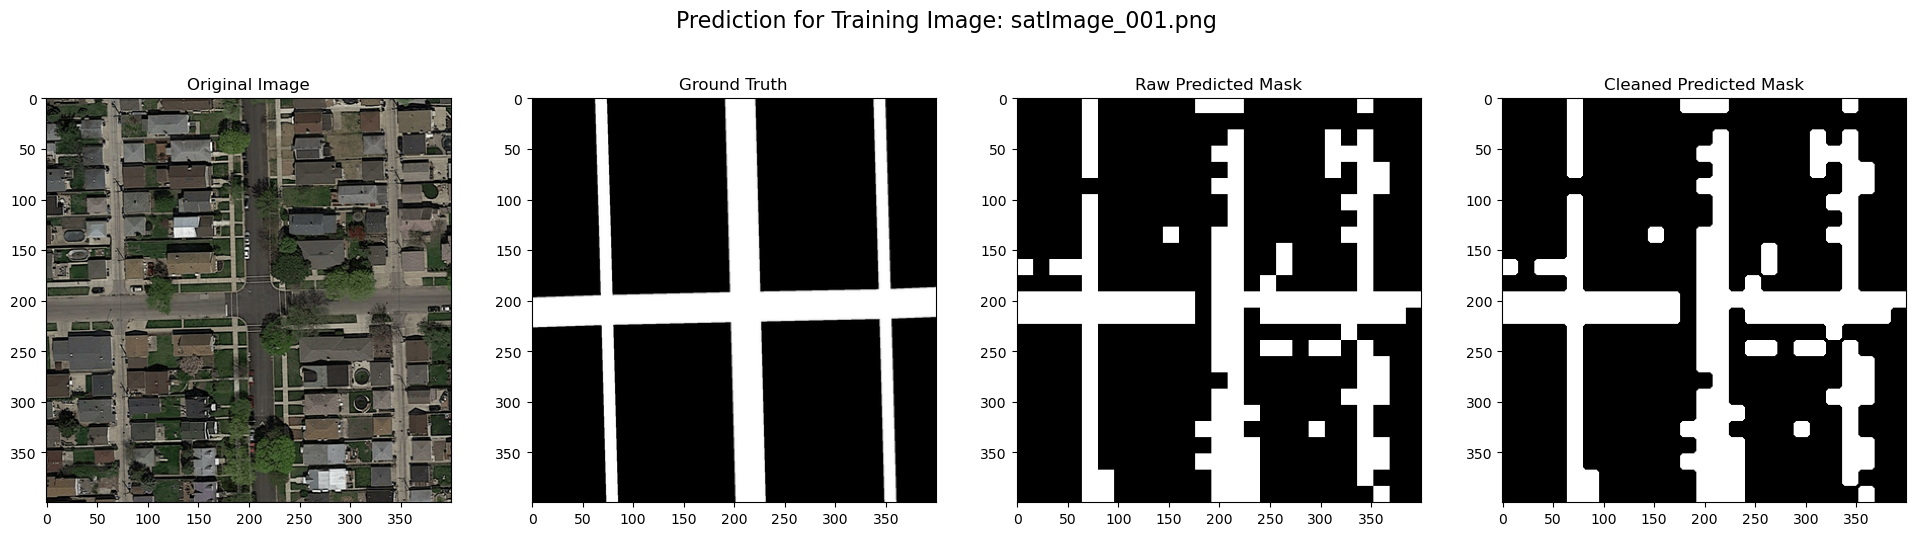


Predicting on training image: satImage_002.png


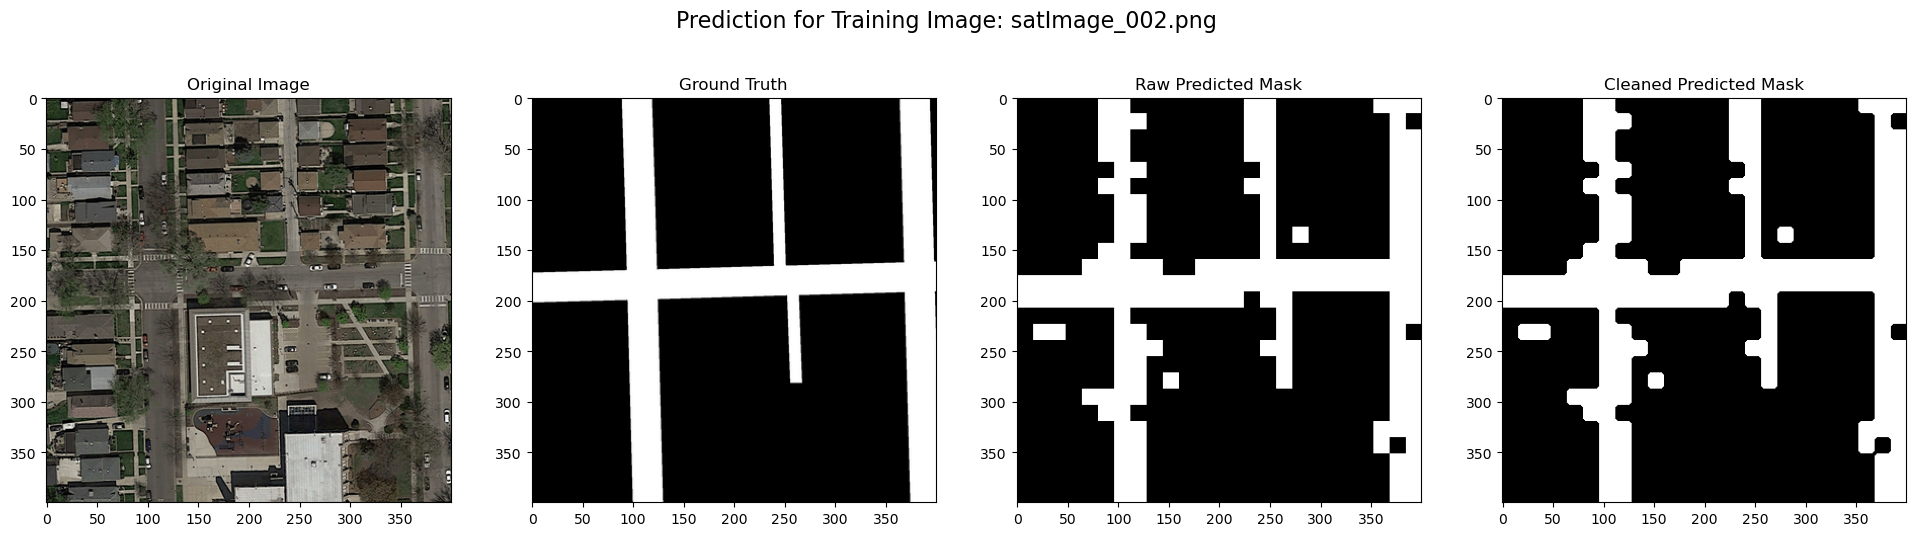


Predicting on training image: satImage_003.png


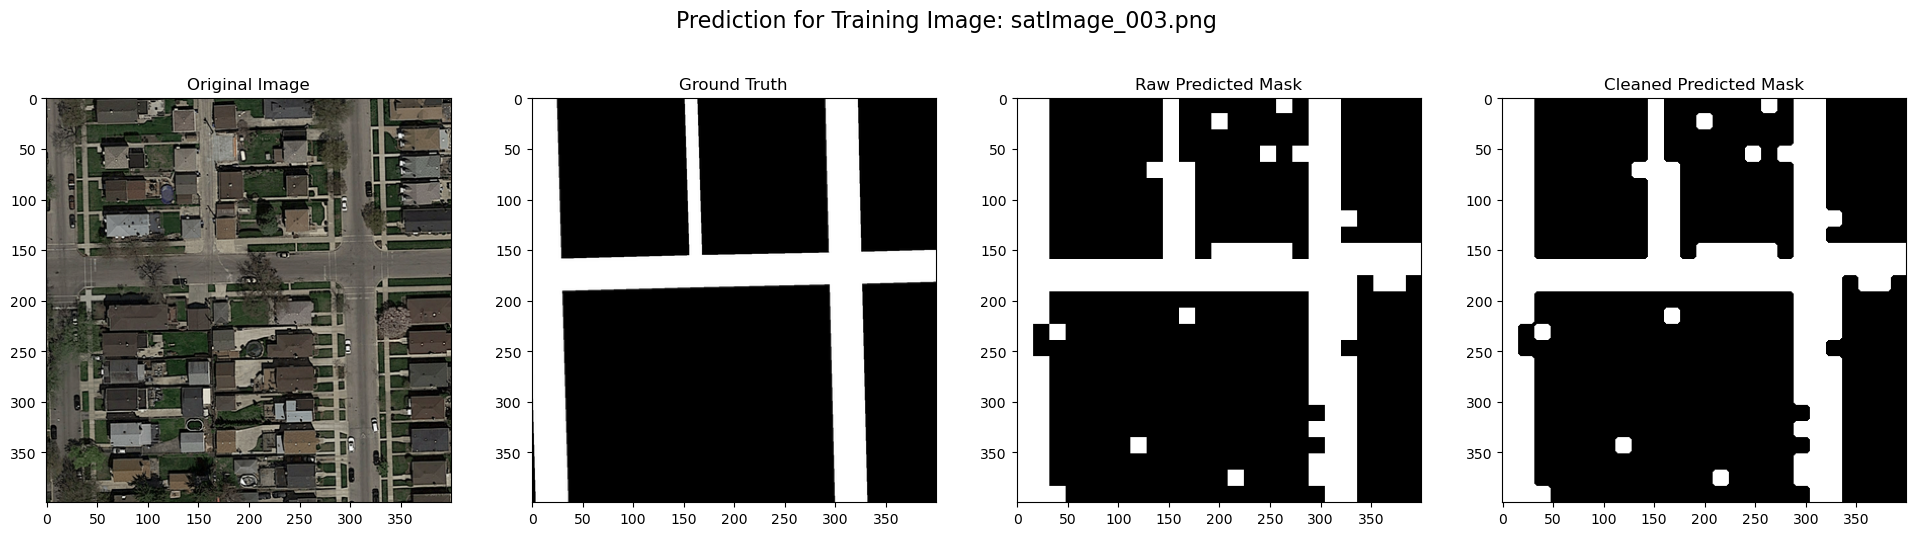

In [40]:
if 'best_rf_classifier' in locals() and best_rf_classifier:
    # Select a few sample training images to visualize
    num_to_display = 3
    print(f"Displaying predictions for the first {num_to_display} training images...")

    for i in range(num_to_display):
        print(f"\nPredicting on training image: {loaded_filenames[i]}")

        # Extract patches and features from the original training image
        img_to_predict = imgs[i]
        patches_to_predict = img_crop(img_to_predict, patch_size, patch_size)
        features_to_predict = np.asarray([extract_combined_features(p) for p in patches_to_predict])

        if features_to_predict.size > 0:
            # Predict labels for each patch
            predicted_labels = best_rf_classifier.predict(features_to_predict)
            
            # Reconstruct the raw mask from the predicted labels
            predicted_mask_raw = label_to_img(img_to_predict.shape[0], img_to_predict.shape[1], patch_size, patch_size, predicted_labels)
            
            # Clean up the raw mask using morphological operations
            cleaned_prediction_mask = cleanup_mask(predicted_mask_raw)

            # --- Visualization ---
            fig, axes = plt.subplots(1, 4, figsize=(24, 6))
            fig.suptitle(f'Prediction for Training Image: {loaded_filenames[i]}', fontsize=16)
            
            # 1. Original Image
            axes[0].imshow(imgs[i])
            axes[0].set_title("Original Image")
            
            # 2. Ground Truth
            axes[1].imshow(gt_imgs[i], cmap='gray')
            axes[1].set_title("Ground Truth")

            # 3. Raw Predicted Mask
            axes[2].imshow(predicted_mask_raw, cmap='gray')
            axes[2].set_title("Raw Predicted Mask")

            # 4. Cleaned Predicted Mask
            axes[3].imshow(cleaned_prediction_mask, cmap='gray')
            axes[3].set_title("Cleaned Predicted Mask")
            
            plt.show()
else:
    print("\nModel not trained. Skipping prediction visualization on training images.")


Displaying predictions for the first 3 test images...

Predicting on: test_set_images/test_1/test_1.png


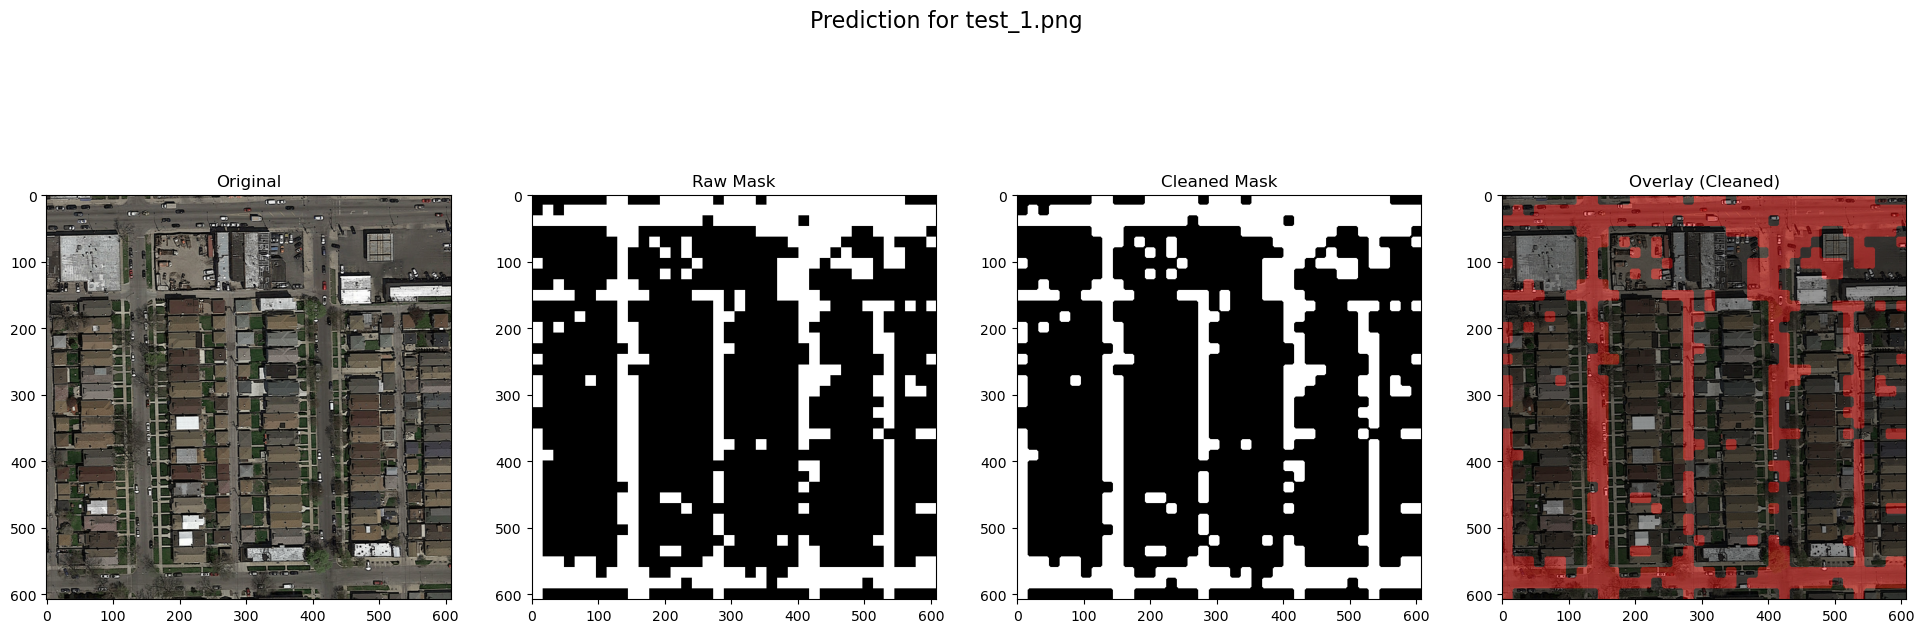


Predicting on: test_set_images/test_10/test_10.png


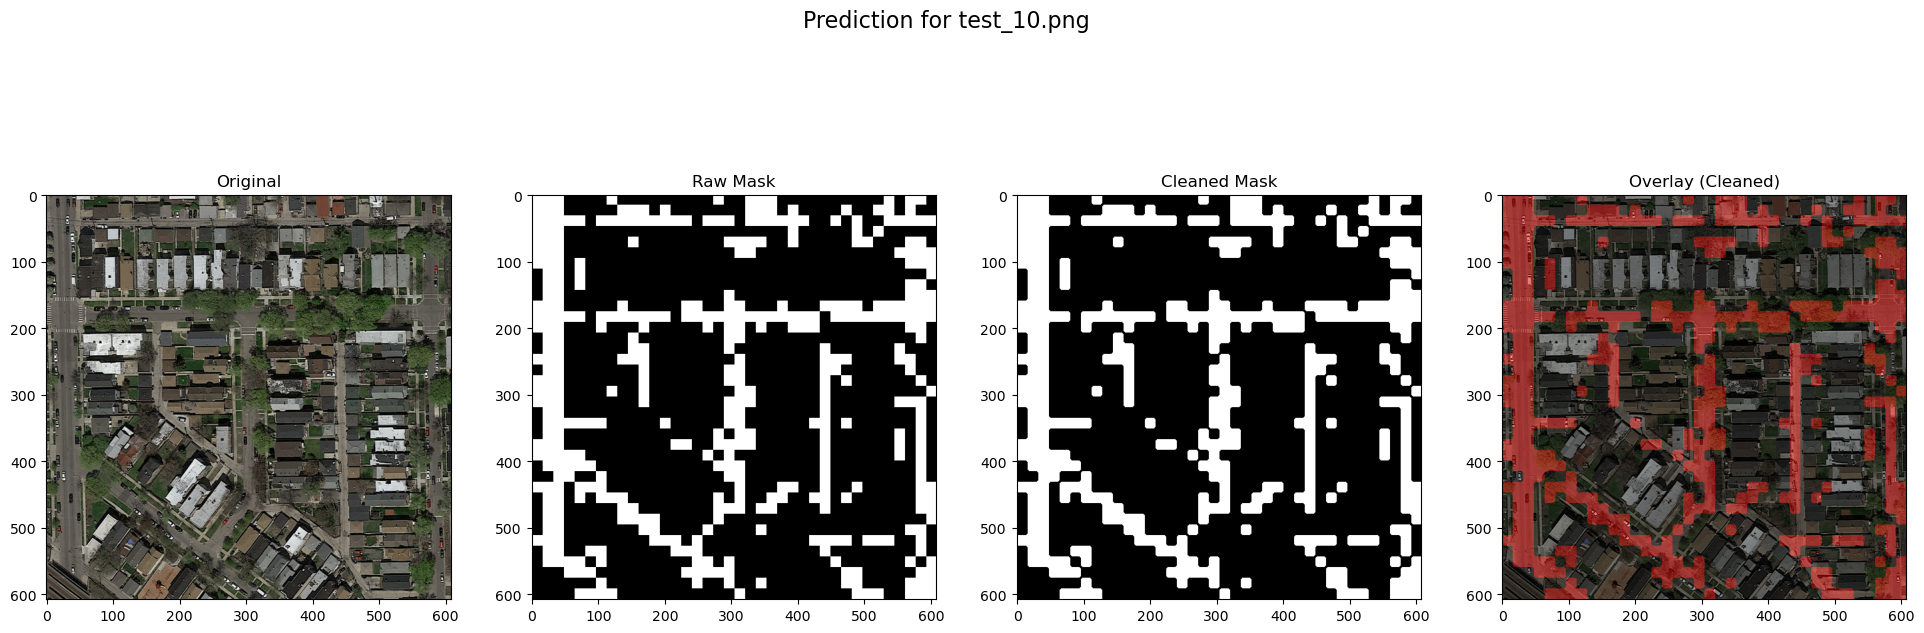


Predicting on: test_set_images/test_11/test_11.png


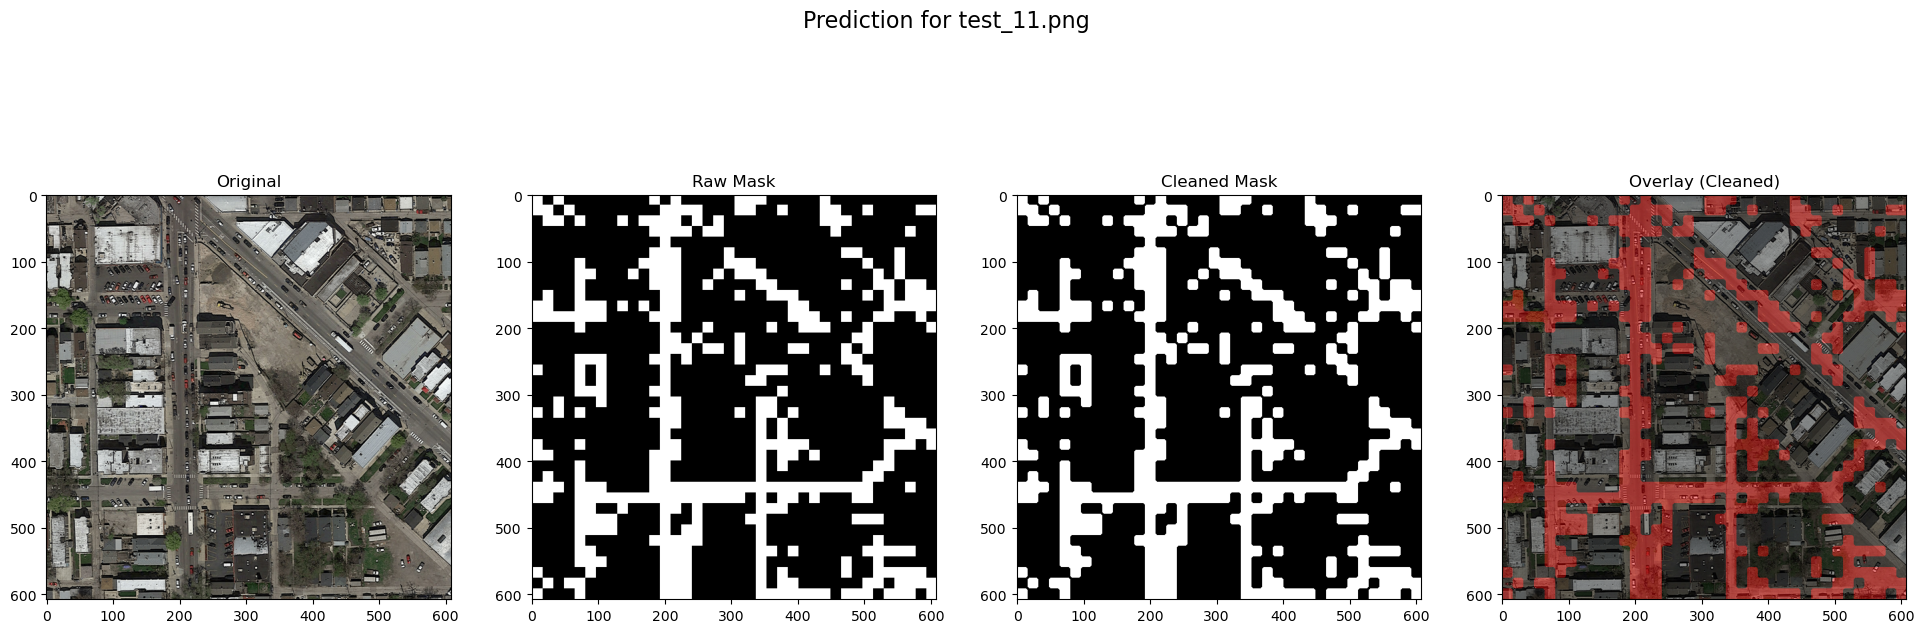

In [41]:
if best_rf_classifier:
    test_image_dir = "test_set_images/"
    test_files = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(test_image_dir)) for f in fn if f.lower().endswith('.png')]
    test_files.sort()
    
    num_to_display = min(3, len(test_files))
    print(f"\nDisplaying predictions for the first {num_to_display} test images...")

    for i in range(num_to_display):
        image_path = test_files[i]
        print(f"\nPredicting on: {image_path}")

        X_new, _, original_img = extract_img_features_combined(image_path)
        
        if X_new.size > 0:
            Z_labels = best_rf_classifier.predict(X_new)
            predicted_mask_raw = label_to_img(original_img.shape[0], original_img.shape[1], patch_size, patch_size, Z_labels)
            cleaned_prediction_mask = cleanup_mask(predicted_mask_raw)
            overlay_image = make_img_overlay(original_img, cleaned_prediction_mask)

            fig, axes = plt.subplots(1, 4, figsize=(24, 8))
            fig.suptitle(f'Prediction for {os.path.basename(image_path)}', fontsize=16)
            axes[0].imshow(original_img); axes[0].set_title("Original")
            axes[1].imshow(predicted_mask_raw, cmap='gray'); axes[1].set_title("Raw Mask")
            axes[2].imshow(cleaned_prediction_mask, cmap='gray'); axes[2].set_title("Cleaned Mask")
            axes[3].imshow(overlay_image); axes[3].set_title("Overlay (Cleaned)")
            plt.show()
else:
    print("\nModel not trained. Skipping prediction visualization.")


In [42]:
if best_rf_classifier:
    test_image_dir = "test_set_images/"
    test_files = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(test_image_dir)) for f in fn if f.lower().endswith('.png')]
    test_files.sort()
    
    print(f"\nFound {len(test_files)} test images to generate submission file.")
    
    submission_entries = []
    if len(test_files) > 0:
        for test_file_path in test_files:
            print(f"Processing {test_file_path} for submission...")
            
            try:
                subdir_name = os.path.basename(os.path.dirname(test_file_path))
                img_number = int(subdir_name.split('_')[1])
            except (IndexError, ValueError) as e:
                print(f"Could not parse image number from path {test_file_path}: {e}. Skipping.")
                continue

            X_test_img, _, test_img_original = extract_img_features_combined(test_file_path)
            
            if X_test_img.size > 0:
                Z_test_img_labels = best_rf_classifier.predict(X_test_img)
                predicted_mask_raw = label_to_img(test_img_original.shape[0], test_img_original.shape[1], patch_size, patch_size, Z_test_img_labels)
                cleaned_mask = cleanup_mask(predicted_mask_raw)
                cleaned_mask_normalized = (cleaned_mask / 255).astype(np.uint8)
                
                for r_idx in range(0, test_img_original.shape[0], patch_size):
                    for c_idx in range(0, test_img_original.shape[1], patch_size):
                        
                        # --- THE FIX IS HERE ---
                        # Corrected the slicing from r_idx+c_idx to r_idx+patch_size
                        patch = cleaned_mask_normalized[r_idx:r_idx+patch_size, c_idx:c_idx+patch_size]
                        
                        label = 1 if np.mean(patch) > 0.5 else 0
                        submission_id = f"{img_number}_{r_idx}_{c_idx}"
                        submission_entries.append({"id": submission_id, "prediction": label})

        if submission_entries:
            submission_df = pd.DataFrame(submission_entries)
            submission_filename = 'submission.csv'
            submission_df.to_csv(submission_filename, index=False)
            print(f"\nSuccessfully created submission file: '{submission_filename}' with {len(submission_df)} entries.")
            print("Sample entries from submission file:")
            print(submission_df.head())
    else:
        print("No test files found to generate submission.")
elif not best_rf_classifier:
    print("\nModel not trained. Skipping submission file generation.")

print("\n--- Notebook Execution Finished ---")


Found 50 test images to generate submission file.
Processing test_set_images/test_1/test_1.png for submission...
Processing test_set_images/test_10/test_10.png for submission...
Processing test_set_images/test_11/test_11.png for submission...
Processing test_set_images/test_12/test_12.png for submission...
Processing test_set_images/test_13/test_13.png for submission...
Processing test_set_images/test_14/test_14.png for submission...
Processing test_set_images/test_15/test_15.png for submission...
Processing test_set_images/test_16/test_16.png for submission...
Processing test_set_images/test_17/test_17.png for submission...
Processing test_set_images/test_18/test_18.png for submission...
Processing test_set_images/test_19/test_19.png for submission...
Processing test_set_images/test_2/test_2.png for submission...
Processing test_set_images/test_20/test_20.png for submission...
Processing test_set_images/test_21/test_21.png for submission...
Processing test_set_images/test_22/test_22.